In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
# Colabではコメントアウトを外す。

# from google.colab import drive
# drive.mount('/content/drive')

# GOOGLE_MY_DRIVE = "/content/drive/MyDrive/code/input/"


INPUT_DIR = "input/"

# INPUT_DIR = GOOGLE_MY_DRIVE

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)

In [5]:
def plot_prediction(forecast, data_test):
    output = pd.merge(forecast, data_test, on='ds', how='left').set_index('ds')

    cond = (output.index >= start) & (output.index < end)
    actual = output[cond]['y']
    pred = output[cond]['yhat']

    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [6]:
def correlation_plot(data, lags=60):
    fig = plt.figure()
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

In [7]:
def learn_plot_prophet(df, start, end, add_feat=None):
    df_train = df[(df['ds'] < start)]
    df_test = df[(df['ds']>= start) & (df['ds'] < end)]
    
    feats = ['ds', 'y']
    if add_feat != None:
        feats.extend(add_feat)
    
    data_train = df_train[feats].copy()
    data_test = df_test[feats].copy()
    
    prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
#     prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    if add_feat != None:
        for f in add_feat:
            prophet.add_regressor(f)
    
    prophet.fit(data_train)
    future = prophet.make_future_dataframe(periods=365, freq='D')
    
    if add_feat != None:
        feat_pred = ['ds']
        feat_pred.extend(add_feat)
        future = pd.merge(future, df[feat_pred], on='ds', how='left')  
    
    forecast = prophet.predict(future)
    fig = prophet.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
    prophet.plot_components(forecast)
    plt.show()
    
    return forecast, data_train, data_test

## 原系列だけでProphet

In [8]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

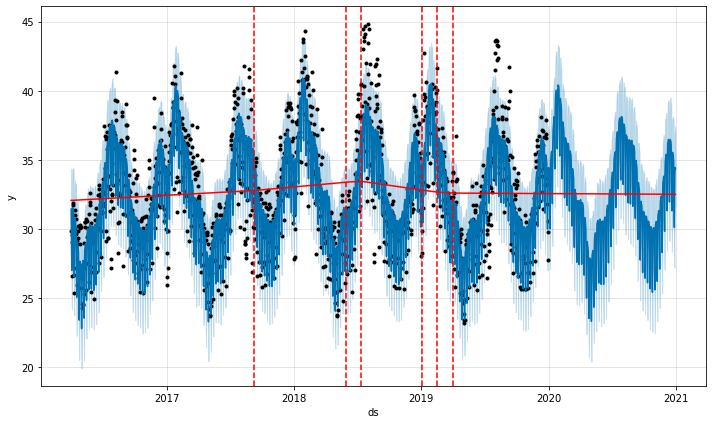

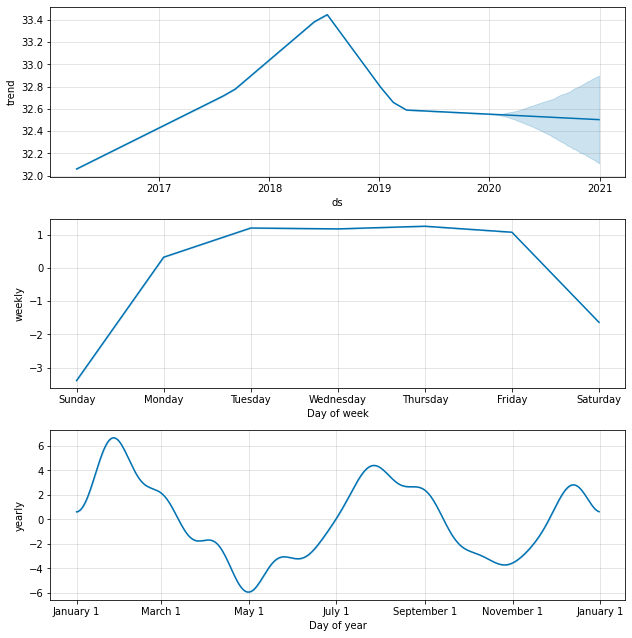

In [9]:
forecast, data_train, data_test = learn_plot_prophet(df, start, end)

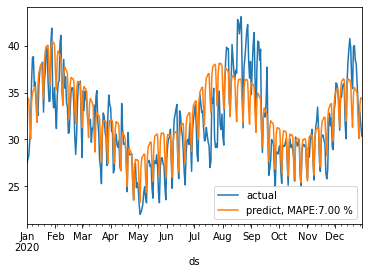

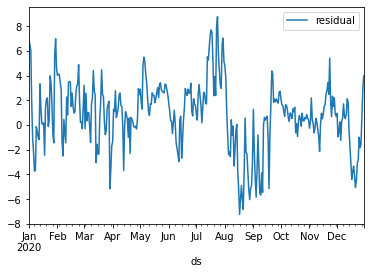

In [10]:
plot_prediction(forecast, data_test)

## 外部変数として気温を追加

In [11]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df

,ds,y,temperature
0,2016-04-01,29.844167,12.8
1,2016-04-02,29.074167,10.5
2,2016-04-03,26.582500,13.1
3,2016-04-04,29.562083,15.6
4,2016-04-05,31.905000,10.8
...,...,...,...
1813,2021-03-19,30.664583,NaN
1814,2021-03-20,27.422083,NaN
1815,2021-03-21,26.930833,NaN
1816,2021-03-22,30.848333,NaN


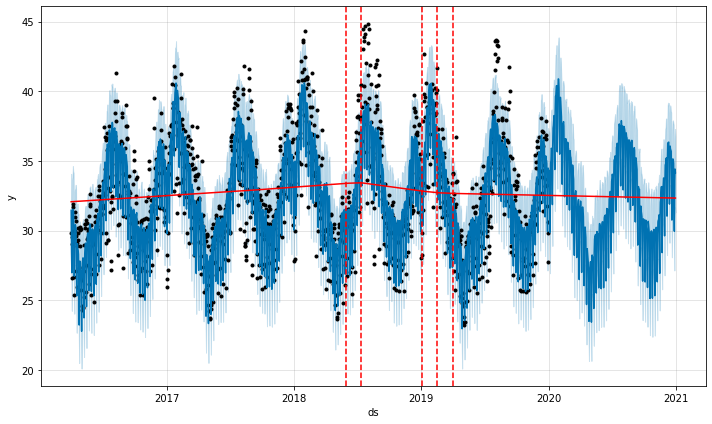

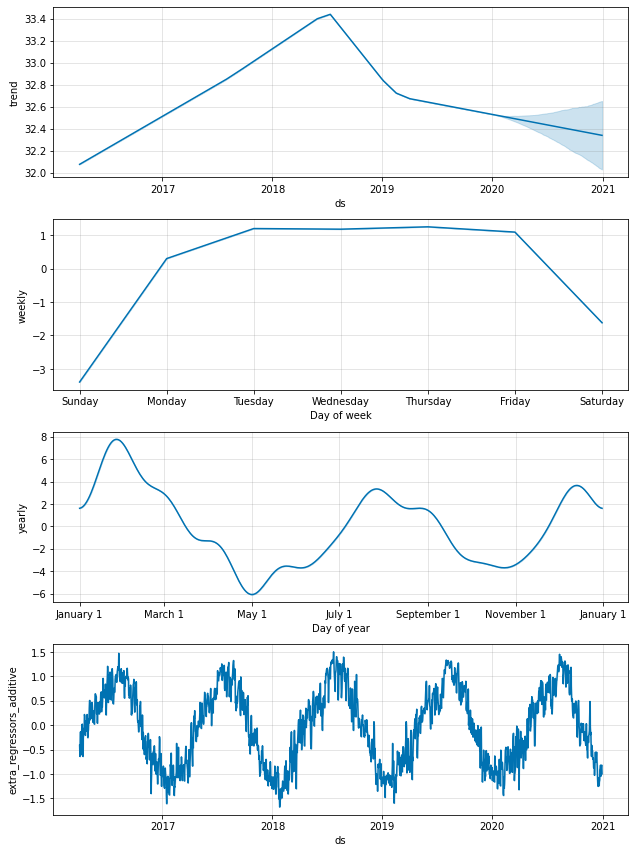

In [12]:
forecast, data_train, data_test = learn_plot_prophet(df, start, end, ['temperature'])

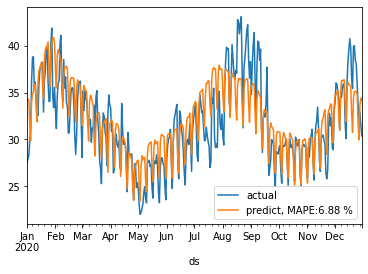

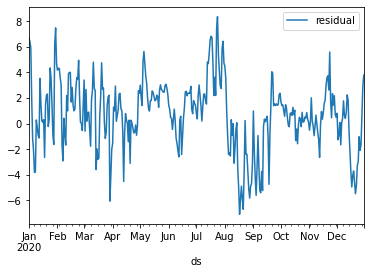

In [13]:
plot_prediction(forecast, data_test)

## 更にGDPを追加

In [14]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')
df

,ds,y,temperature,gdp
0,2016-04-01,29.844167,12.8,1.342716
1,2016-04-02,29.074167,10.5,1.342716
2,2016-04-03,26.582500,13.1,1.342716
3,2016-04-04,29.562083,15.6,1.342716
4,2016-04-05,31.905000,10.8,1.342716
...,...,...,...,...
1813,2021-03-19,30.664583,NaN,NaN
1814,2021-03-20,27.422083,NaN,NaN
1815,2021-03-21,26.930833,NaN,NaN
1816,2021-03-22,30.848333,NaN,NaN


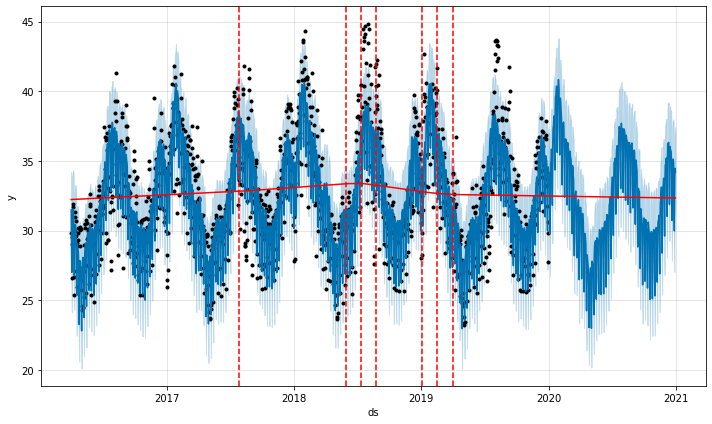

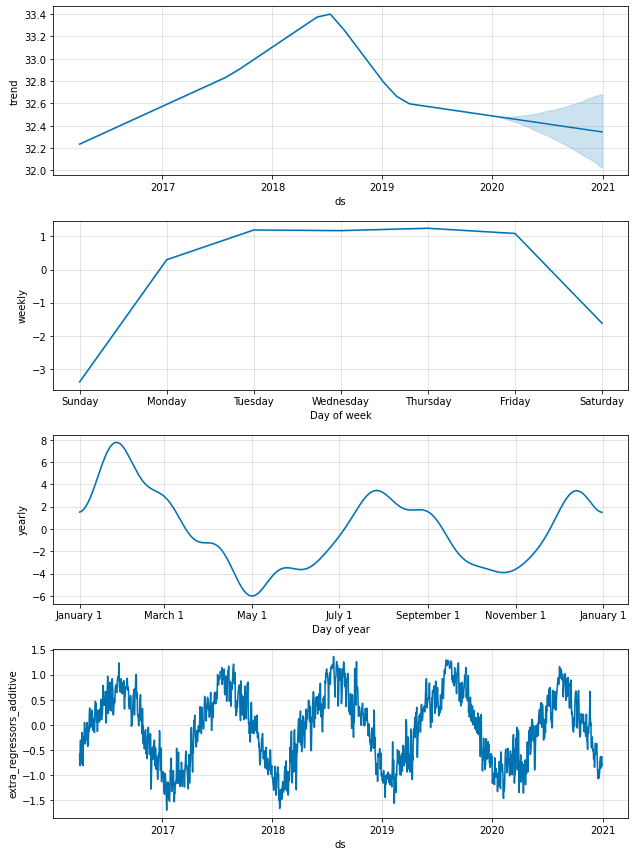

In [15]:
forecast, data_train, data_test = learn_plot_prophet(df, start, end, ['temperature', 'gdp'])

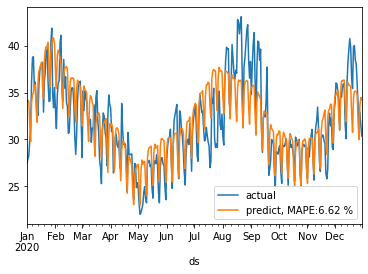

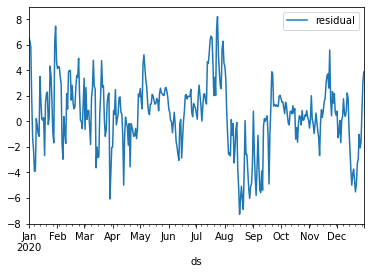

In [16]:
plot_prediction(forecast, data_test)

## 残差の確認

Jack Bera: 	 Jarque_beraResult(statistic=5.638255013259405, pvalue=0.0596579711927363)


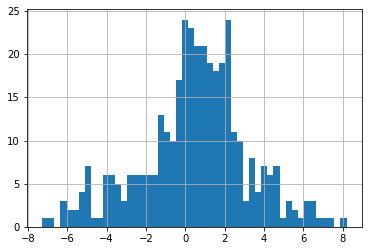

In [17]:
output = pd.merge(forecast, data_test, on='ds', how='left').set_index('ds')

cond = (output.index >= start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

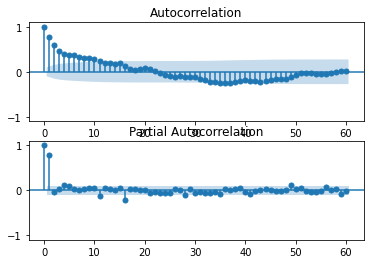

1 223.5531559745102 1.5183685631331953e-50
2 351.83036244034884 3.990318053442464e-77
3 427.73386175022733 2.174256306599137e-92
4 484.74012695637214 1.3374760326113494e-103
5 537.7590958697879 5.6262241399536596e-114
6 587.304748387115 1.2764070260815806e-123
7 629.6030519383595 1.0242404010197599e-131
8 665.577232579599 1.8366031948508942e-138
9 698.5748134820385 1.4004376081209258e-144
10 731.1249188137544 1.302090747250123e-150


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [18]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

## 自己回帰項を入れる

In [19]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

df['y_shift_1'] = df['y'].shift(1).bfill()
df

,ds,y,temperature,gdp,y_shift_1
0,2016-04-01,29.844167,12.8,1.342716,29.844167
1,2016-04-02,29.074167,10.5,1.342716,29.844167
2,2016-04-03,26.582500,13.1,1.342716,29.074167
3,2016-04-04,29.562083,15.6,1.342716,26.582500
4,2016-04-05,31.905000,10.8,1.342716,29.562083
...,...,...,...,...,...
1813,2021-03-19,30.664583,NaN,NaN,31.407083
1814,2021-03-20,27.422083,NaN,NaN,30.664583
1815,2021-03-21,26.930833,NaN,NaN,27.422083
1816,2021-03-22,30.848333,NaN,NaN,26.930833


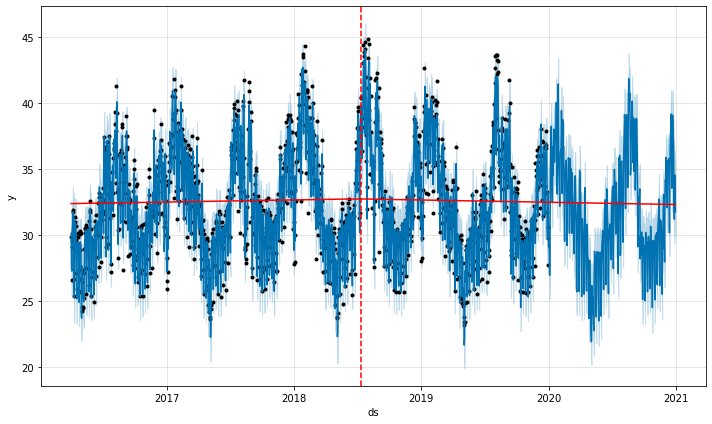

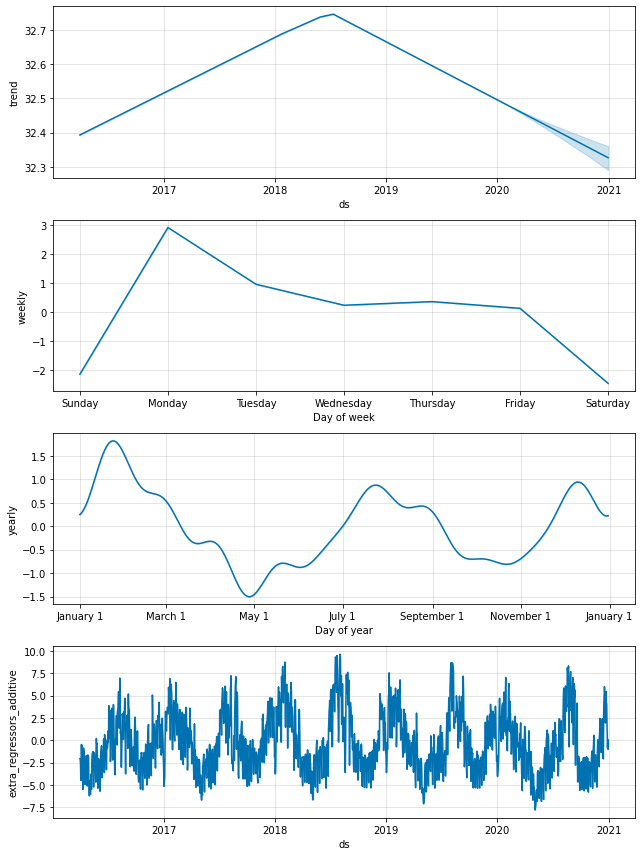

In [20]:
forecast, data_train, data_test = learn_plot_prophet(df, start, end, ['temperature', 'gdp', 'y_shift_1'])

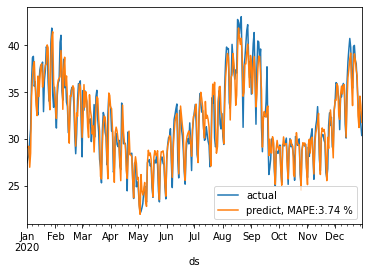

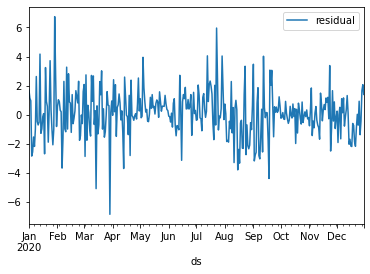

In [21]:
plot_prediction(forecast, data_test)

Jack Bera: 	 Jarque_beraResult(statistic=49.21802133616179, pvalue=2.0532575639720108e-11)


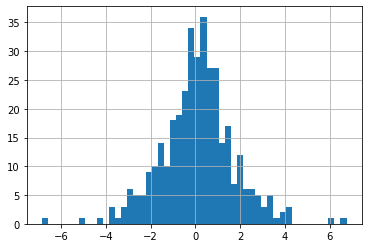

In [22]:
output = pd.merge(forecast, data_test, on='ds', how='left').set_index('ds')

cond = (output.index >= start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

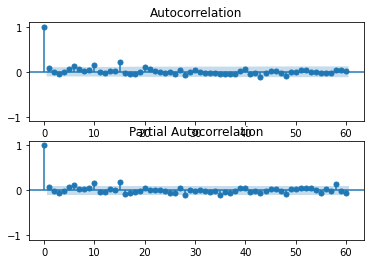

1 2.5181796382558965 0.11254043184952779
2 2.521919518334914 0.2833819175478691
3 3.8333019060416267 0.2800362507105542
4 3.899391634914774 0.4197929081464188
5 5.7670144598579975 0.3295535664816217
6 11.198746095509971 0.08242476319026693
7 12.448425605431419 0.08674344821795299
8 12.603149915384842 0.12625309939012697
9 13.264747913856576 0.1509880506614387
10 22.0715676251793 0.01474413127327697


/home/ryoji/.cache/pypoetry/virtualenvs/timeseries-weK0nu0g-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [23]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

In [25]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')

df['y_shift_2'] = df['y'].shift(2).bfill()
df

,ds,y,temperature,gdp,y_shift_2
0,2016-04-01,29.844167,12.8,1.342716,29.844167
1,2016-04-02,29.074167,10.5,1.342716,29.844167
2,2016-04-03,26.582500,13.1,1.342716,29.844167
3,2016-04-04,29.562083,15.6,1.342716,29.074167
4,2016-04-05,31.905000,10.8,1.342716,26.582500
...,...,...,...,...,...
1813,2021-03-19,30.664583,NaN,NaN,30.880833
1814,2021-03-20,27.422083,NaN,NaN,31.407083
1815,2021-03-21,26.930833,NaN,NaN,30.664583
1816,2021-03-22,30.848333,NaN,NaN,27.422083


## 前々日の自己回帰

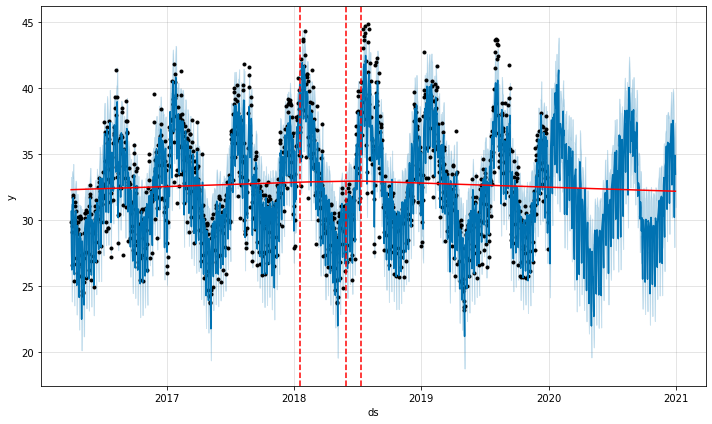

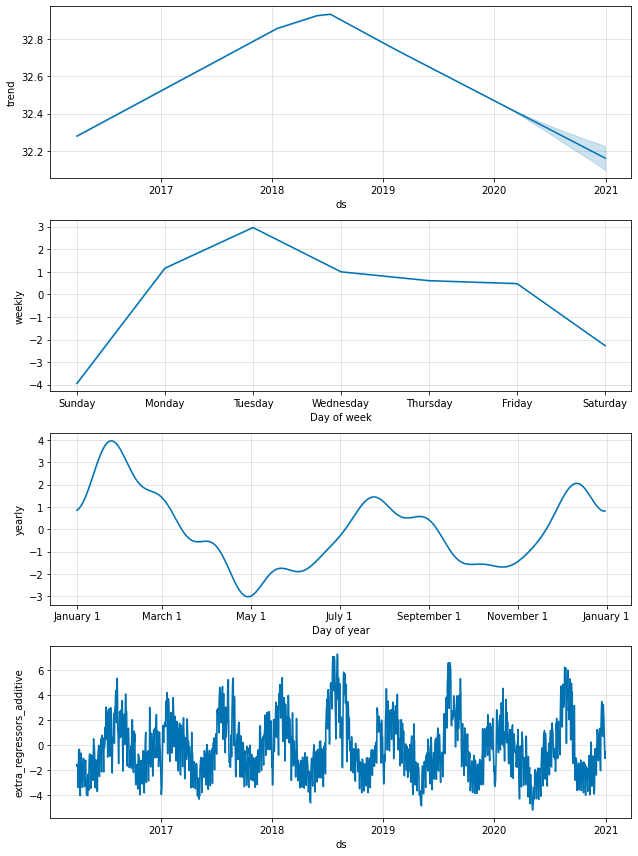

In [26]:
forecast, data_train, data_test = learn_plot_prophet(df, start, end, ['temperature', 'gdp', 'y_shift_2'])

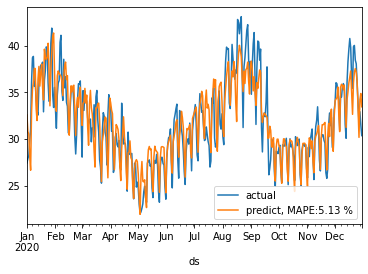

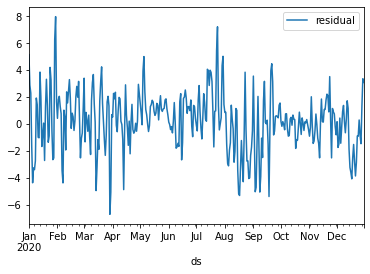

In [27]:
plot_prediction(forecast, data_test)